# Network analysis using the origins and divisions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
import json

In [2]:
MAIN_FILE_PATH = "../../1832_v4_preprocessed.csv"

recensement = pd.read_csv(MAIN_FILE_PATH)
recensement.head()

,nom_rue,no_maison,chef_annee_naissance,chef_origine,chef_annee_arrivee,chef_vocation,page,division,chef_vocation_class,chef_origine_class
0,marterey,1,1764.0,tolochenaz,1786.0,charon,1,1-2,NaN,morges
1,marterey,2,NaN,rolle,1821.0,marechal-ferrant,1,1-2,artisanat,rolle
2,marterey,3,1785.0,pailly,NaN,lingere,1,1-2,service,moudon
3,marterey,3,NaN,gingins,NaN,rentier,1,1-2,rente,NaN
4,marterey,3,NaN,gingins,NaN,rentier,1,1-2,rente,NaN


In [3]:
# Create the bipartite graph
G = nx.Graph()

# Add nodes from class_origine and chef_vocation_categorie
G.add_nodes_from(recensement['chef_origine_class'], bipartite=0)
G.add_nodes_from(recensement['chef_vocation_class'], bipartite=1)

# Add edges between class_origine and chef_vocation_categorie
for origine, group in recensement.groupby('chef_origine_class'):
    for job_category, count in group.groupby('chef_vocation_class').size().items():
        G.add_edge(origine, job_category, weight=count)

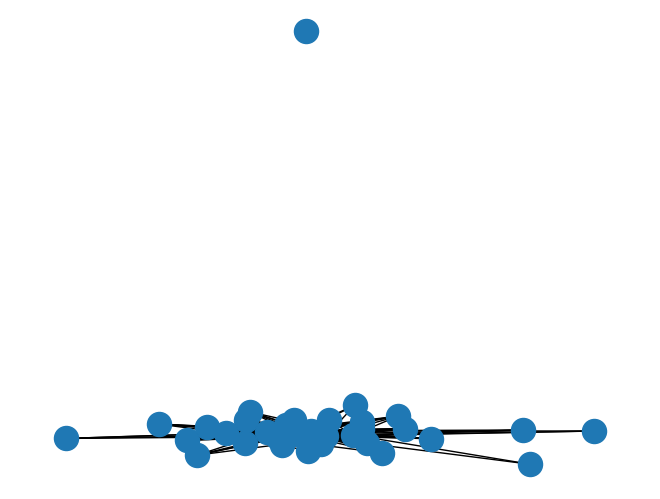

In [4]:
nx.draw(G)

In [5]:
# Get the edges of the graph with their weights
edges = G.edges(data=True)
edge_data = [(u, v, d['weight']) for u, v, d in edges]

# Create a DataFrame from the edge data
df = pd.DataFrame(edge_data, columns=['Origine_category', 'Job_category', 'Weight'])

# Save the DataFrame to a CSV file
df.to_csv('bipartite_graph.csv', index=False)

In [6]:
nx.write_gexf(G, "bipartite_origine_category_job_category.gexf")

In [7]:
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv("./bipartite_graph.csv")

# Get unique division and job_category names
origine = df["Origine_category"].unique()
job_categories = df["Job_category"].unique()

# Create dictionaries to store nodes and links
nodes = []
links = []

# Iterate over divisions
for i, ori in enumerate(origine):
    # Add division node to nodes dictionary
    nodes.append({"id": str(i), "label": str(ori), "type": "origine_category", "size": int(df[df["Origine_category"] == ori]["Weight"].sum())})
    
    # Iterate over job categories and add corresponding links
    for j, cat in enumerate(job_categories):
        weight = int(df[(df["Origine_category"] == ori) & (df["Job_category"] == cat)]["Weight"].sum())
        if weight > 0:
            links.append({"source": str(i), "target": str(cat), "weight": weight})
            
# Iterate over job categories
for i, cat in enumerate(job_categories):
    # Add job category node to nodes dictionary
    nodes.append({"id": str(cat), "label": str(cat), "type": "job_category", "size": int(df[df["Job_category"] == cat]["Weight"].sum())})
    
# Create JSON dictionary
json_dict = {"nodes": nodes, "links": links}

# Write JSON dictionary to file
with open("./bipartite_origine_category_type_metiers.json", "w") as f:
    json.dump(json_dict, f, indent=4)